In [51]:
import numpy as np
from PIL import Image 
from pathlib import Path
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import random
import cv2
from tensorflow.keras.utils import Sequence


# Define Function

In [5]:
def get_parent_folder_name(path_str):
    return Path(path_str).parent.name

# import Data path list

In [6]:
label_array_dict = {
    "cats": np.array([0]),
    "dogs": np.array([1])
}
index_label_list = ["cats", "dogs"]

train_image_path_list = glob(f"./training_set/*/*.jpg")
test_image_path_list = glob(f"./test_set/*/*.jpg")

print(len(train_image_path_list))
print(len(test_image_path_list))

8005
2023


callable => 함수 호출 할수 있냐 => object method 안에 __call__() 정의 되어 있냐
subscriptable => 인덱스 호출 할 수 있냐 => object method 안에 __getitem__() 정의 되어 있냐
iterable => iterable 한 객체로 만들수 있냐 => object method 안에 __iter__() 정의 되어 있냐

# Why We need to Define \_\_len\_\_() magic method function in class

In [7]:
example_list = [1, 2, 3]

print(len(example_list))
print(example_list.__len__())

3
3


# Why We need to Define \_\_getitem()\_\_ magic method function in class

=> make object subscritable

In [8]:
example_list = [1, 2, 3]

print(example_list[1])
print(example_list.__getitem__(1))

2
2


# Define Dataset (Keras)
Dataset: 한개의 index를 받아 path를 얻어 한개의 data (image_array, label_array) 를 얻을 수 있는 객체
DataLoader: 한개의 index를 받아 Dataset을 사용해 여려개의 데이터가 있는 Batch를 얻을수 있는 객체

In [56]:
class Dataset():
    def __init__(self, image_path_list, label_array_dict):
        self.image_path_list = image_path_list
        self.label_array_dict = label_array_dict
    
    def __len__(self):
        return len(self.image_path_list)
    
    def __getitem__(self, idx):
        image_path = self.image_path_list[idx]
        image_pil_obj = Image.open(image_path)
        image_array = np.array(image_pil_obj)
        image_array = cv2.resize(image_array, (256, 256), 
                                 interpolation=cv2.INTER_LINEAR)
        label_str = get_parent_folder_name(image_path)
        label_array = label_array_dict[label_str]
        return image_array, label_array
    
    
class DataSequence(Sequence):
    def __init__(self, dataset, batch_size, shuffle=True):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.idx_pool = list(range(len(self.dataset)))
        
    def __len__(self):
        return np.ceil(len(self.dataset) / batch_size)
    
    def __getitem__(self, batch_idx):
        start = batch_idx * self.batch_size
        end = (batch_idx + 1) * self.batch_size
        data_idx_list = self.idx_pool[start:end] 
        
        
        batch_data = [self.dataset[data_idx] for data_idx in data_idx_list]
        batch_data = self.collate_fn(batch_data)
#         batch_data = []
#         for data_idx in data_idx_list:
#             data = self.dataset[data_idx]
#             batch_data.append(data)
    
        return batch_data
    
    def shuffle_idx_pool(self):
        random.shuffle(self.idx_pool)
    
    def on_epoch_begin(self, epoch):
        self.shuffle_idx_pool()
        
    def collate_fn(self, batch_data):
        batch_image_array = []
        batch_label_array = []
        for image_array, label_array in batch_data:
            batch_image_array.append(image_array)
            batch_label_array.append(label_array)
        batch_image_array = np.stack(batch_image_array, axis=0)
        batch_label_array = np.stack(batch_label_array, axis=0)
        
        return batch_image_array, batch_label_array 
    
    def collate_fn_efficient(self, batch_data):
        batch_image_array = np.empty((self.batch_size, 280, 300, 3), dtype="float32")
        batch_label_array = np.empty((self.batch_size, 1), dtype="float32")
        for idx, (image_array, label_array) in enumerate(batch_data):
            batch_image_array[idx] = image_array
            batch_label_array[idx] = label_array
            
        return batch_image_array, batch_label_array

# INTER POLATION

In [57]:
train_dataset = Dataset(train_image_path_list, label_array_dict)
train_data_sequence = DataSequence(train_dataset, batch_size=10, shuffle=True)

In [58]:
data = train_dataset[0]

In [59]:
batch_data = train_data_sequence[0]

# Unused Code

In [41]:
train_image_path = train_image_path_list[0]
label_str = get_parent_folder_name(train_image_path)
label = label_index_dict[label_str]

print(train_image_path)
print(label_str)
print(label)

./training_set\cats\cat.1.jpg
cats
0


./training_set\cats\cat.1.jpg
[0]
0
cats


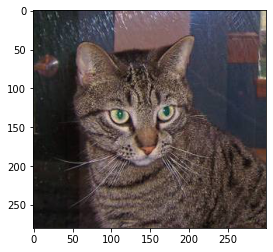

In [61]:
data = train_dataset[0]
image_array, label_array = data
label_index = np.round(label_array).item()
label_str = index_label_list[label_index]
print(train_image_path_list[0])
print(label_array)
print(label_index)
print(label_str)
plt.imshow(image_array)
plt.show()